<a href="https://colab.research.google.com/github/Rahulx911/grid-6.0/blob/main/object_count_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install ensemble-boxes  # Install the 'ensemble-boxes' library
!git clone https://github.com/ultralytics/yolov5  # Clone the YOLOv5 repository
%cd yolov5
!pip install -r requirements.txt  # Install YOLOv5 dependencies


Cloning into 'yolov5'...
remote: Enumerating objects: 16998, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (140/140), done.
remote: Total 16998 (delta 103), reused 113 (delta 53), pack-reused 16805 (from 1)
Receiving objects: 100% (16998/16998), 15.72 MiB | 18.29 MiB/s, done.
Resolving deltas: 100% (11632/11632), done.
/content/yolov5


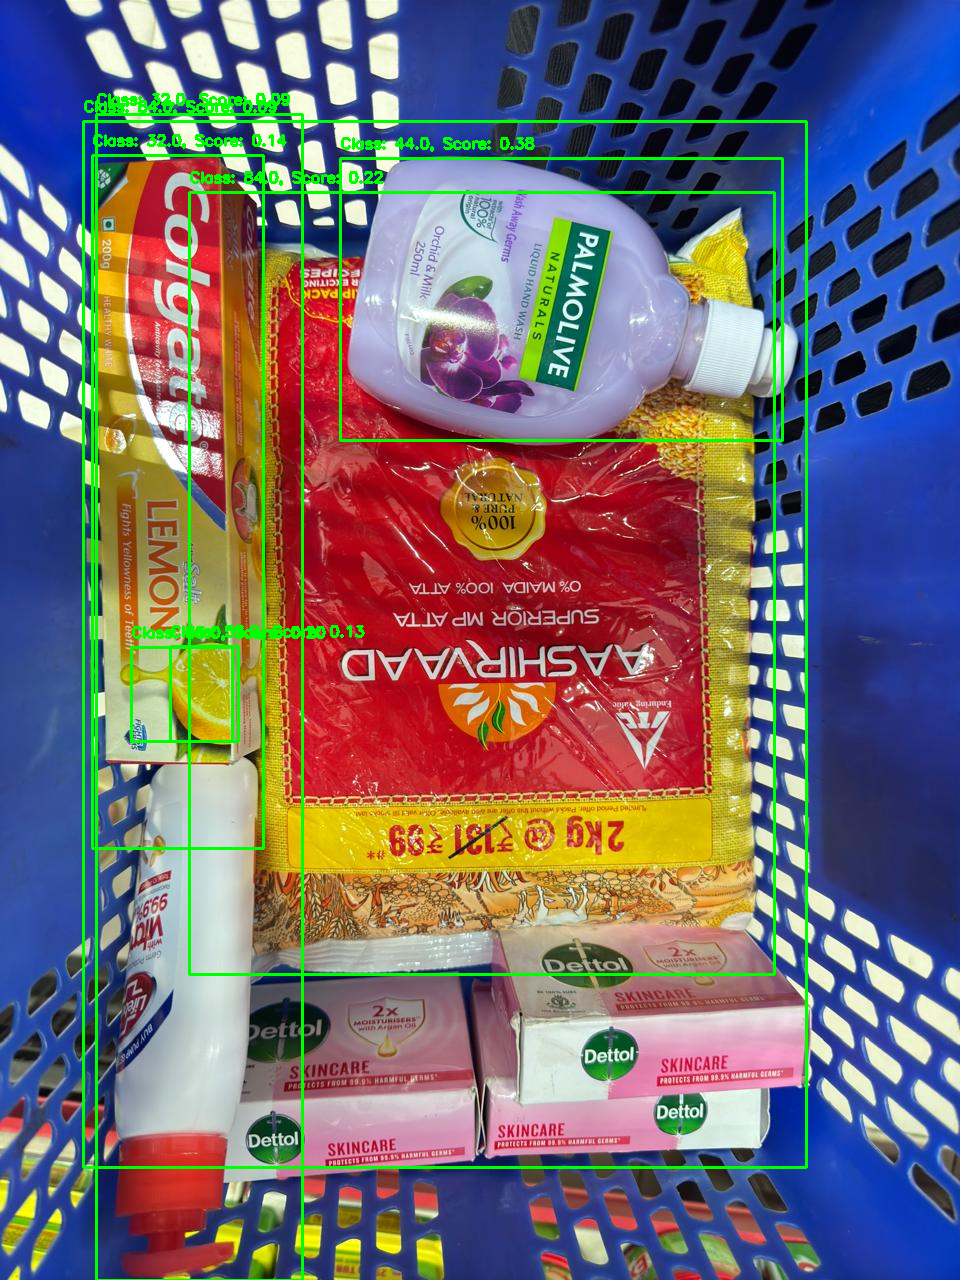

Total number of detected objects : 7


In [40]:
!pip install ensemble-boxes  # Install the 'ensemble-boxes' library

import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn, retinanet_resnet50_fpn, ssdlite320_mobilenet_v3_large
import cv2
import numpy as np
from torchvision.transforms import functional as F
from google.colab.patches import cv2_imshow
from ensemble_boxes import weighted_boxes_fusion  # Import WBF library
from torchvision.ops import nms  # For non-maximum suppression

# List of pre-trained models from torchvision
models = [
    fasterrcnn_resnet50_fpn(pretrained=True).eval(),
    retinanet_resnet50_fpn(pretrained=True).eval(),
    ssdlite320_mobilenet_v3_large(pretrained=True).eval()  # Add MobileNet-SSD
]

# Load the image
img = cv2.imread("/content/test-img-2.jpeg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB format
img_tensor = F.to_tensor(img_rgb)  # Convert image to tensor
img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension

# Store all bounding boxes, scores, classes, and their respective model confidences
all_boxes = []
all_scores = []
all_classes = []

# Confidence threshold to filter low-quality predictions
score_threshold = 0.25

# Run detection for each model
for model in models:
    with torch.no_grad():
        predictions = model(img_tensor)[0]  # Run model on the image tensor

    # Filter out low-confidence detections
    high_conf_idx = predictions['scores'] > score_threshold
    boxes = predictions['boxes'][high_conf_idx].cpu().numpy()
    scores = predictions['scores'][high_conf_idx].cpu().numpy()
    classes = predictions['labels'][high_conf_idx].cpu().numpy()

    # Normalize bounding boxes to [0, 1] for WBF
    height, width = img.shape[:2]
    norm_boxes = boxes / [width, height, width, height]

    # Store results for Weighted Box Fusion
    all_boxes.append(norm_boxes.tolist())
    all_scores.append(scores.tolist())
    all_classes.append(classes.tolist())

# Use Weighted Box Fusion to combine predictions from all models
iou_threshold = 0.8  # IoU threshold for WBF
boxes_wbf, scores_wbf, labels_wbf = weighted_boxes_fusion(
    all_boxes, all_scores, all_classes, iou_thr=iou_threshold, skip_box_thr=score_threshold
)

# Denormalize boxes after WBF
boxes_wbf = np.array(boxes_wbf) * [width, height, width, height]
scores_wbf = np.array(scores_wbf)
labels_wbf = np.array(labels_wbf)

# Further filter the boxes using NMS
nms_threshold = 0.7  # IoU threshold for NMS
boxes_tensor = torch.tensor(boxes_wbf)
scores_tensor = torch.tensor(scores_wbf)
nms_indices = nms(boxes_tensor, scores_tensor, nms_threshold).numpy()

# Select the final boxes, scores, and classes after NMS
final_boxes = boxes_wbf[nms_indices]
final_scores = scores_wbf[nms_indices]
final_classes = labels_wbf[nms_indices]

# Draw the final bounding boxes on the image
for i, box in enumerate(final_boxes):
    x1, y1, x2, y2 = map(int, box)
    score = final_scores[i]
    label = final_classes[i]

    # Draw the bounding box and label
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Draw green box
    text = f'Class: {label}, Score: {score:.2f}'
    cv2.putText(img, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Display the final image with bounding boxes and detected objects from all models
cv2_imshow(img)

print(f"Total number of detected objects : {len(final_boxes)}")
